In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("final_data.csv", parse_dates=["Date"])
df

,Price_eth,addresses_active_count_onchain,RevUSD_market,Vader_Comp,Vol._futures,Vader_Neu,bids_market,supply_miner_held_by_all_addresses_within_one_hop_of_a_mining_entity_native_units_onchain,volatility_market,AdrActCnt_market,...,bidAskSpread_market,hash_rate_mean_onchain,HashRate_market,TxCnt_market,VtyDayRet30d_market,supply_held_by_top_100_addresses_onchain,Vader_Neg,Date,target,test
0,1099.52,1230529,55986515.21,0.20215,8150.0,0.854741,2.696802e+07,2822587.597,186.406136,1040203.0,...,0.599972,145160753.6,1.582156e+08,260173.0,0.034317,2481892.551,0.039323,2021-01-05,1.612101,False
1,1207.77,1344921,34231235.25,0.20215,19470.0,0.854741,3.261763e+07,2822077.477,184.314315,914351.0,...,0.583837,163652569.0,1.485729e+08,231423.0,0.054134,2474776.497,0.039323,2021-01-06,1.535109,False
2,1224.35,1292297,22532356.46,0.20215,16830.0,0.854741,3.224854e+07,2821826.388,217.307109,817115.0,...,0.643784,155331252.4,9.512298e+07,232056.0,0.051059,2486440.508,0.039323,2021-01-07,0.661790,False
3,1215.73,1237271,38861905.57,0.20215,15380.0,0.854741,3.492305e+07,2822390.243,265.300557,695892.0,...,0.682708,136839436.2,1.109758e+08,190234.0,0.030858,2501364.372,0.039323,2021-01-08,-2.878639,False
4,1091.47,1211948,57409115.37,0.20215,22210.0,0.854741,3.533249e+07,2821437.198,434.242095,1053426.0,...,0.975458,157757649.3,1.593504e+08,289324.0,0.030561,2506447.879,0.039323,2021-01-11,-0.828492,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1645.82,968985,24045257.30,0.20215,10310.0,0.854741,3.612133e+07,2535681.337,40.577728,968985.0,...,7.179025,398153805.9,3.981538e+08,433684.0,0.021518,2861831.938,0.039323,2023-08-31,-0.188931,True
668,1629.00,1051172,16511404.94,0.20215,6920.0,0.854741,4.695970e+07,2540456.775,34.591558,981056.0,...,7.182452,417508504.3,2.576097e+08,286289.0,0.014097,2868529.984,0.039323,2023-09-01,-0.035084,True
669,1634.46,940913,38214791.46,0.20215,4760.0,0.854741,5.251132e+07,2531580.566,18.351362,772112.0,...,7.174868,342854665.7,3.603416e+08,592036.0,0.023862,2865732.583,0.039323,2023-09-05,-0.059476,True
670,1633.18,1001123,29899213.71,0.20215,5240.0,0.854741,5.297339e+07,2532717.983,25.093918,1020140.0,...,7.167681,364053703.3,4.304215e+08,387748.0,0.020988,2859586.844,0.039323,2023-09-06,0.606220,True


# Check missing dates

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>], dtype=object))

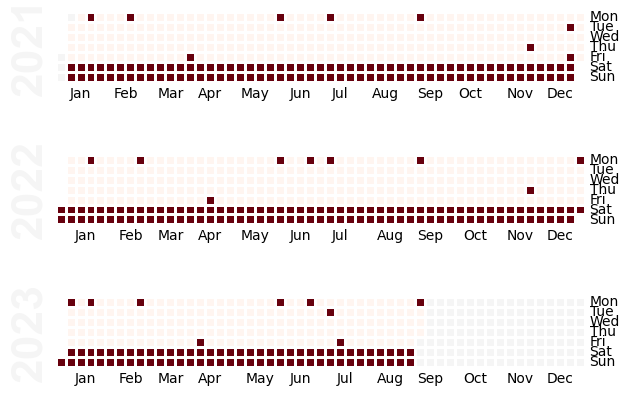

In [3]:
import calmap

dates = pd.to_datetime(df["Date"])
tmp = pd.Series(1, index=pd.date_range(start="2021-01-05", end="2023-09-07"))
tmp[dates] = 0
calmap.calendarplot(tmp)

# Data Ingestion

In [4]:
df_train, df_test = df[~df["test"]], df[df["test"]]
X_train, X_test = df_train.drop(["Date", "target", "test"], axis=1), df_test.drop(
    ["Date", "target", "test"], axis=1
)
y_train, y_test = df_train["target"], df_test["target"]
len(X_train), len(y_train), len(X_test), len(y_test)

(537, 537, 135, 135)

# Model Training

In [5]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [6]:
# # NO GRIDSEARCH! Custom hyperparameters in the next cell already

# # Parameters for GridSearch
# parameters = {
#     "loss": ["absolute_error", "squared_error"],
#     "learning_rate": [0.05, 0.075, 0.1, 0.15],
#     "max_depth": [3, 5, 8, 10],
#     "max_features": ["log2", "sqrt"],
#     "subsample": [0.8, 0.9, 1.0],
#     "n_estimators": [50, 100, 150],
# }
# # passing the scoring function in the GridSearchCV
# # we keep cv as 2 to save time
# clf = GridSearchCV(
#     GradientBoostingRegressor(random_state=42),
#     parameters,
#     scoring="neg_root_mean_squared_error",
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
# )

# clf.fit(X_train, y_train)
# clf.best_score_, clf.best_params_

In [7]:
best_params = {
    "loss": "squared_error",
    "max_depth": 3,
    "max_features": 8,
    "subsample": 0.8,
    "n_estimators": 256,
}

gbr = GradientBoostingRegressor(
    random_state=132,
    **best_params
    # **clf.best_params_
)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_features=8, n_estimators=256, random_state=132,
                          subsample=0.8)

In [8]:
# Predict on validation set
y_pred = gbr.predict(X_test)
y_train_pred = gbr.predict(X_train)

# Calculate the Mean Squared Error on the validation set
mean_squared_error(y_test, y_pred, squared=False)

0.9935908582969614

# Predictions over train and test period

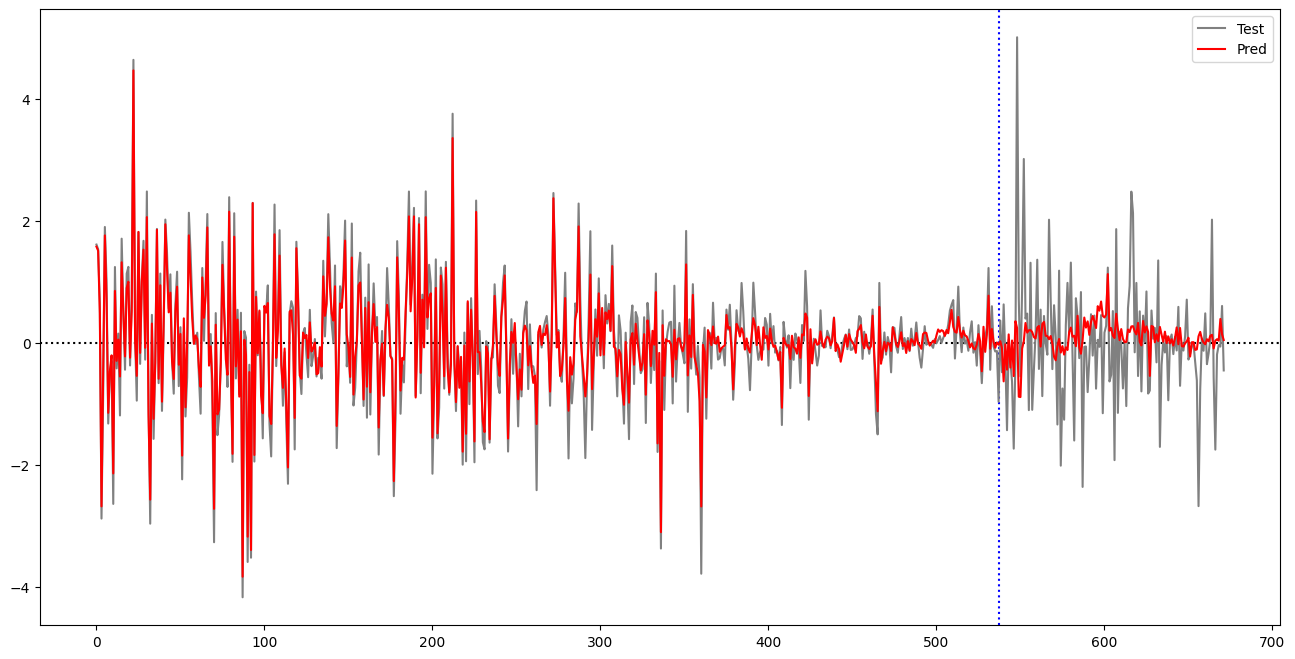

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.axvline(x=len(y_train), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linestyle=":")
plt.plot(np.concatenate([y_train, y_test]), color="grey", label="Test")
plt.plot(np.concatenate([y_train_pred, y_pred]), color="red", label="Pred")
plt.legend()
plt.show()

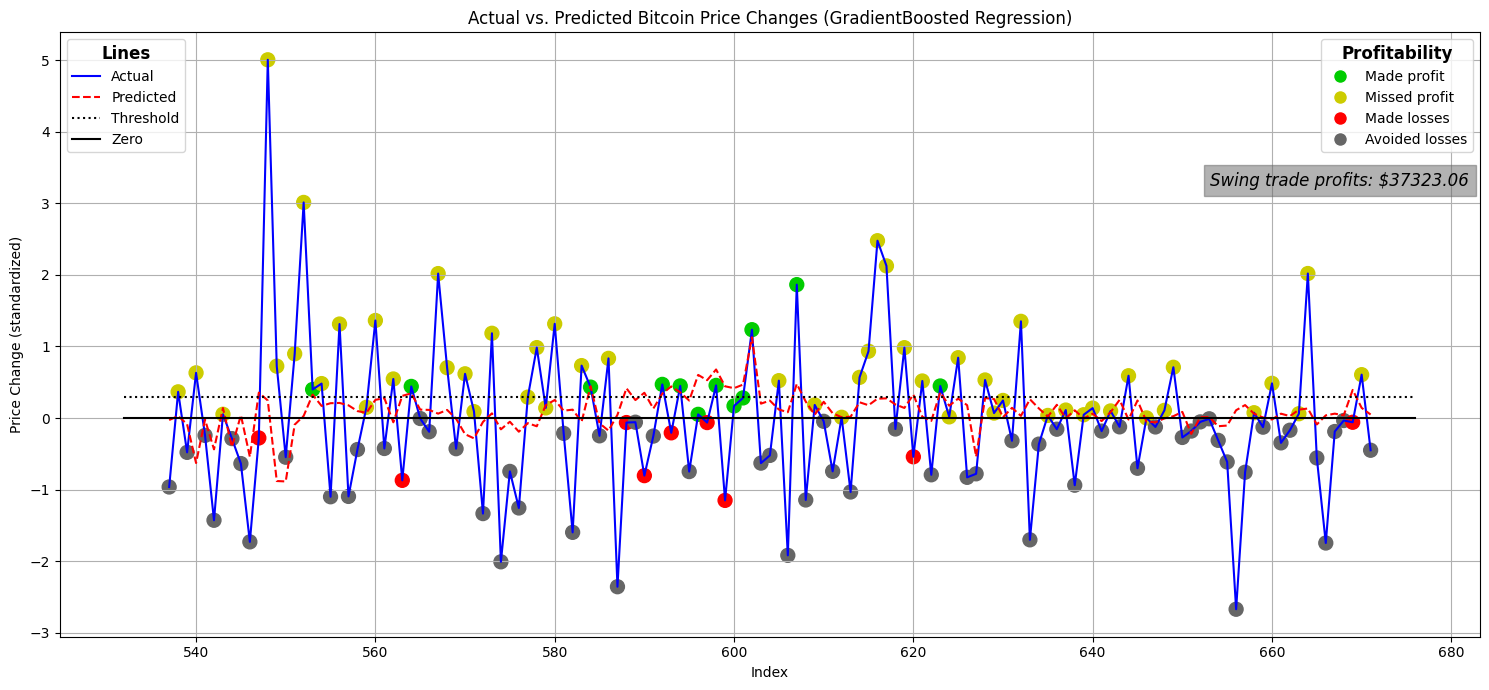

In [10]:
from SwingTradingSimulator import generate_simulation

# Example usage (without scaling factor for predicted values)
generate_simulation(y_test, y_pred, "GradientBoosted Regression", threshold=0.3)